# This notebook is dedicated to the creation of 5 classification model with the 1 methode. 


In [8]:
import os
import numpy as np
import time
import pandas as pd

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub # pip install tensorflow_hub

In [2]:
train_dir='the_wildfire_dataset/the_wildfire_dataset/train'
validation_dir= 'the_wildfire_dataset/the_wildfire_dataset/val'
test_dir='the_wildfire_dataset/the_wildfire_dataset/test'

IMG_SIZE = (224, 224)
BATCH_SIZE = 10
# Setting the labels for each folder
labels= ['Smoke_from_fires', 'Both_smoke_and_fire', 'Forested_areas_without_confounding_elements', 'Fire_confounding_elements', 'Smoke_confounding_elements']


In [4]:
import os
# This cel is important. There is on image that can't be import use in the models so we just remove it

fichier_a_supprimer ="the_wildfire_dataset/the_wildfire_dataset/val/fire/Both_smoke_and_fire/desktop.ini"
try:
    os.remove(fichier_a_supprimer)
except OSError as e:
    print(f'Error')

Error


In [6]:
''' These function are here for the import :
get_labels is use to define the lables depending on the folder they are in
decode_img is just made to resize and normalize every images
process_path just apply the previous fonction to every file in each folder
'''

def get_labels(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    #primary_label = parts[-3] == primary_classes
    auxiliary_label = parts[-2] == labels
    return  auxiliary_label
def decode_img(img):
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, [IMG_SIZE[0], IMG_SIZE[1]]) / 255.0
    return img

# Function to preprocess each image file by reading, decoding, and labeling
def process_path(file_path):
    labels = get_labels(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, labels


In [9]:
''' Here we just use the function before in the right files to create the dataset'''

train_dataset = tf.data.Dataset.list_files(str(train_dir + '/*/*/*'), shuffle=True)
train_dataset = train_dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

validation_dataset = tf.data.Dataset.list_files(str(validation_dir + '/*/*/*'), shuffle=True)
validation_dataset = validation_dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.list_files(str(test_dir + '/*/*/*'), shuffle=False)
test_dataset = test_dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

''' To be honest i didn't know  how to import the whole dataset with the 5 class as labels so we just use and understand a 
preexisting kaggle code that already existed'''

In [42]:
''' Creating the batch'''
train_dataset = train_dataset.batch(BATCH_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

Found 410 files belonging to 2 classes.


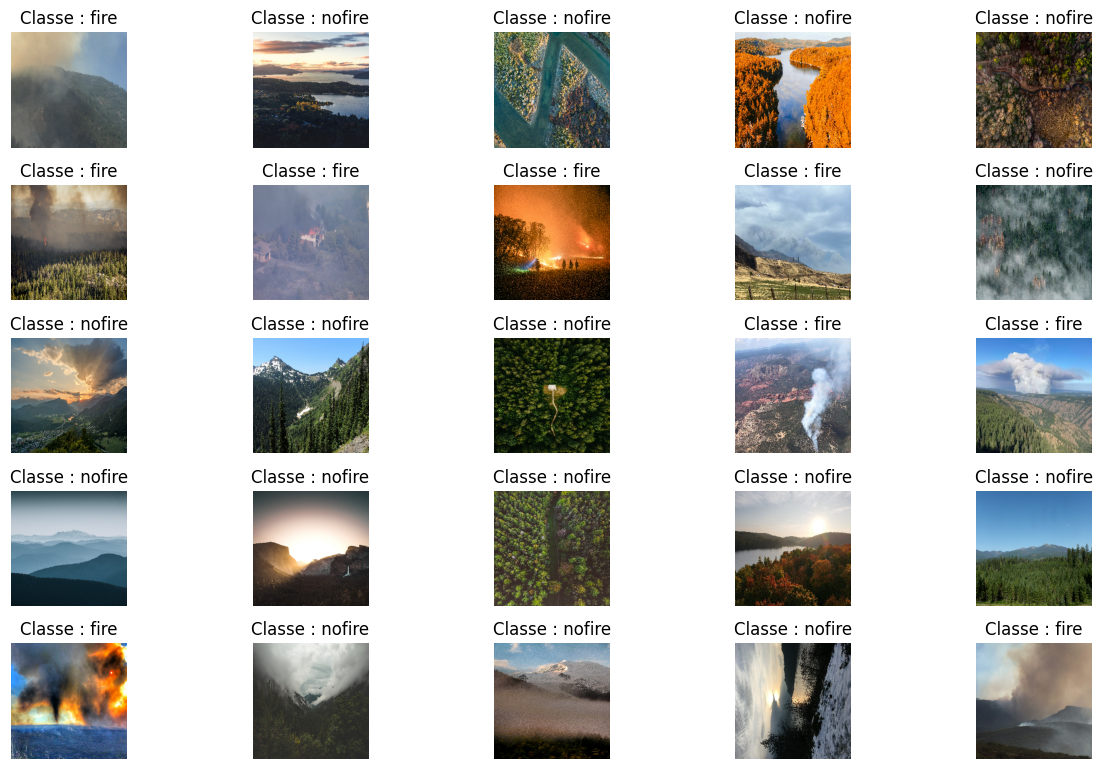

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

''' This cell is just there to plot the data with the labels existing'''
labels_basic=['fire','nofire']

num_rows = 5
num_cols = 5
num_images = num_rows * num_cols

''' the only way we fond to modify the size of every image of a subplot like this one'''
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

test = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  seed=123,
  label_mode='categorical',
  image_size=(224, 224),
  batch_size=num_images,
  shuffle=True)


for images, labels_ in test.take(1):
   for i in range(num_images):
       ax = plt.subplot(num_rows, int(num_images/num_rows), i + 1)
       set_size(10,6)
       plt.imshow(images[i].numpy().astype('uint8'))
       plt.title(f'Classe : {labels_basic[np.flatnonzero(labels_[i] == True)[0]]}')
       plt.axis("off")




plt.tight_layout()

# Afficher la figure
plt.show()



In [46]:
feature_extractor_layer = hub.KerasLayer("https://www.kaggle.com/models/tensorflow/efficientnet/frameworks/TensorFlow2/variations/b0-classification/versions/1", input_shape=(224, 224, 3), trainable=False)

In [47]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(len(labels))
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1000)              5330564   
                                                                 
 dense_1 (Dense)             (None, 5)                 5005      
                                                                 
Total params: 5335569 (20.35 MB)
Trainable params: 5005 (19.55 KB)
Non-trainable params: 5330564 (20.33 MB)
_________________________________________________________________


In [48]:
model.compile(
  optimizer=tf.keras.optimizers.legacy.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [49]:
import keras

''' so we use tensorboard_logdir as a callback function and we only used 3 epoch since this model took long time to run. it's for the 5 class classification '''
tensorboard_logdir = os.path.join(os.getcwd(),'logs','tensorboard') # Let's log Tensorboard data to this folder
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=tensorboard_logdir) # Create a Tensorboard "callback"
history = model.fit(train_dataset, epochs=3,validation_data=validation_dataset,
                    callbacks=[tensorboard_callback])

Epoch 1/3
189/189 [==============================] - 250s 1s/step - loss: 1.5771 - acc: 0.3752 - val_loss: 1.5442 - val_acc: 0.4229
Epoch 2/3
189/189 [==============================] - 190s 1s/step - loss: 1.5211 - acc: 0.4330 - val_loss: 1.4947 - val_acc: 0.4353
Epoch 3/3
189/189 [==============================] - 190s 998ms/step - loss: 1.4792 - acc: 0.4377 - val_loss: 1.4568 - val_acc: 0.4403


In [50]:
# Just unfreeze the model as usual and use fit it again, this time we used more epoch since we got better upgrades in the accuracy
feature_extractor_layer.trainable = True
model.compile(optimizer=keras.optimizers.legacy.Adam(1e-3),  # Very low learning rate
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['acc'])
model.fit(train_dataset, epochs=5,validation_data=validation_dataset,
                    callbacks=[tensorboard_callback])

Epoch 1/5
189/189 [==============================] - 409s 2s/step - loss: 1.5642 - acc: 0.4515 - val_loss: 1.5946 - val_acc: 0.3905
Epoch 2/5
189/189 [==============================] - 363s 2s/step - loss: 1.5400 - acc: 0.4388 - val_loss: 1.4867 - val_acc: 0.4527
Epoch 3/5
189/189 [==============================] - 363s 2s/step - loss: 1.5030 - acc: 0.4557 - val_loss: 1.4670 - val_acc: 0.4726
Epoch 4/5
189/189 [==============================] - 359s 2s/step - loss: 1.4386 - acc: 0.5204 - val_loss: 1.4131 - val_acc: 0.5124
Epoch 5/5
189/189 [==============================] - 341s 2s/step - loss: 1.4185 - acc: 0.5130 - val_loss: 1.3982 - val_acc: 0.4851


tf.Tensor([ True False False False False], shape=(5,), dtype=bool)
tf.Tensor([False False  True False False], shape=(5,), dtype=bool)
tf.Tensor([False False  True False False], shape=(5,), dtype=bool)
tf.Tensor([ True False False False False], shape=(5,), dtype=bool)
tf.Tensor([ True False False False False], shape=(5,), dtype=bool)
tf.Tensor([False  True False False False], shape=(5,), dtype=bool)
tf.Tensor([False  True False False False], shape=(5,), dtype=bool)
tf.Tensor([False False False  True False], shape=(5,), dtype=bool)
tf.Tensor([False False  True False False], shape=(5,), dtype=bool)
tf.Tensor([False False  True False False], shape=(5,), dtype=bool)
tf.Tensor([False  True False False False], shape=(5,), dtype=bool)
tf.Tensor([ True False False False False], shape=(5,), dtype=bool)
tf.Tensor([ True False False False False], shape=(5,), dtype=bool)
tf.Tensor([False False  True False False], shape=(5,), dtype=bool)
tf.Tensor([False  True False False False], shape=(5,), dtype=b

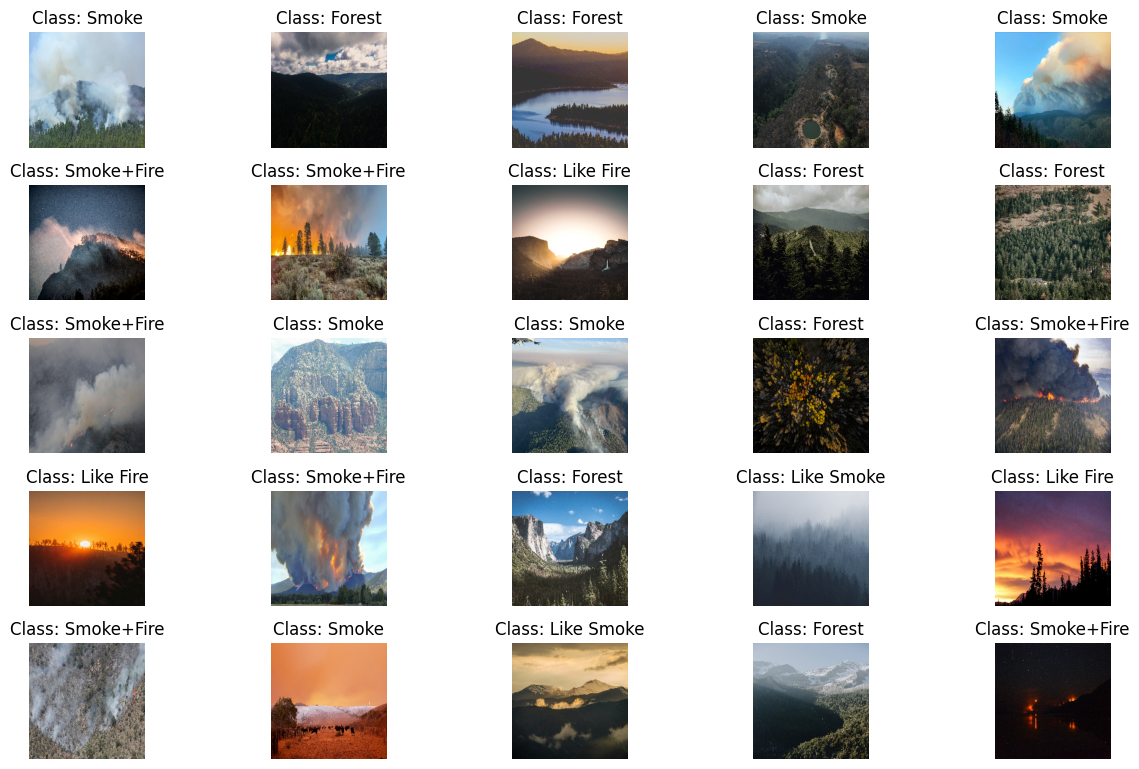

In [17]:
class_lab=["Smoke","Smoke+Fire","Forest","Like Fire","Like Smoke"]

# This is cell is dedicated to plotting i recreate a new dataset with unnormalized data 

def process_path_plot(file_path):
    labels = get_labels(file_path)
    img = tf.io.read_file(file_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, [IMG_SIZE[0], IMG_SIZE[1]])

    return img, labels

test_plot = tf.data.Dataset.list_files(str(test_dir + '/*/*/*'), shuffle=True)
test_plot = test_plot.map(process_path_plot)
test_plot= test_plot.batch(num_images)

for images, labels_ in test_plot.take(1):
  for i in range(num_images):
       ax = plt.subplot(num_rows, int(num_images/num_rows), i + 1)
       set_size(10,6)
       plt.imshow(images[i].numpy().astype('uint8'))
       plt.title(f'Class: {class_lab[np.flatnonzero(labels_[i] == True)[0]]}')
       plt.axis("off")
       i+=1

plt.tight_layout()

# Afficher la figure
plt.show()

In [51]:
model.evaluate(test_dataset)
#just evaluate the model

41/41 [==============================] - 35s 841ms/step - loss: 1.3967 - acc: 0.5000


[1.3966606855392456, 0.5]

In [52]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
img_height=224
img_width=224
test_ = tf.keras.preprocessing.image_dataset_from_directory(
  "the_wildfire_dataset/the_wildfire_dataset/test",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=1,
  label_mode='categorical',shuffle=False)
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
test_=test_.map(lambda x, y: (normalization_layer(x), y))
predictions = model.predict(test_dataset)

Found 410 files belonging to 2 classes.
41/41 [==============================] - 37s 822ms/step


In [53]:
pred = np.argmax(predictions,axis=-1)
pred

array([2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 3, 0, 3, 2, 0, 0, 0, 3, 0, 0,
       2, 3, 2, 0, 0, 0, 0, 0, 2, 3, 2, 2, 2, 3, 3, 0, 2, 0, 2, 0, 2, 2,
       0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 3, 3, 3, 0, 0, 0, 0, 0, 0,
       0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 3, 0, 3, 2, 0, 2, 0, 0, 3, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 2, 3, 0, 0, 0, 2, 0, 2,
       0, 0, 0, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 3, 3, 3, 0, 2, 3, 2, 3, 3, 3, 3, 3, 2, 2, 0, 2, 3,
       2, 3, 2, 3, 3, 3, 2, 2, 3, 2, 3, 2, 2, 2, 0, 3, 3, 3, 3, 2, 3, 2,
       2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 0, 2, 2, 0, 2, 2, 2,
       2, 0, 2, 2, 3, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 0, 2, 2,
       3, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 3, 2, 0, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 0, 0, 3, 0, 2, 2, 2, 2,
       3, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [44]:
# Obtenir les vraies classes des données de test
vraies_classes = []

for images,labels_ in test_dataset:
    for i in range(len(labels_)):

        vraies_classes+=[np.flatnonzero(labels_[i] == True)[0] ]
vraies_classes=np.array(vraies_classes)

In [45]:
vraies_classes

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [54]:

# Calculer la matrice de confusion
matrice_confusion = confusion_matrix(vraies_classes, pred)

# Afficher la matrice de confusion
print("Matrice de confusion :")
print(matrice_confusion)

# Afficher le rapport de classification
rapport_classification = classification_report(vraies_classes, pred)
print("Rapport de classification :")
print(rapport_classification)


Matrice de confusion :
[[ 79   0  13   8   0]
 [ 31   0  19   9   0]
 [ 12   0 102  14   0]
 [  3   0  25  24   0]
 [ 46   0  18   7   0]]
Rapport de classification :
              precision    recall  f1-score   support

           0       0.46      0.79      0.58       100
           1       0.00      0.00      0.00        59
           2       0.58      0.80      0.67       128
           3       0.39      0.46      0.42        52
           4       0.00      0.00      0.00        71

    accuracy                           0.50       410
   macro avg       0.29      0.41      0.33       410
weighted avg       0.34      0.50      0.40       410



c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<function matplotlib.pyplot.show(close=None, block=None)>

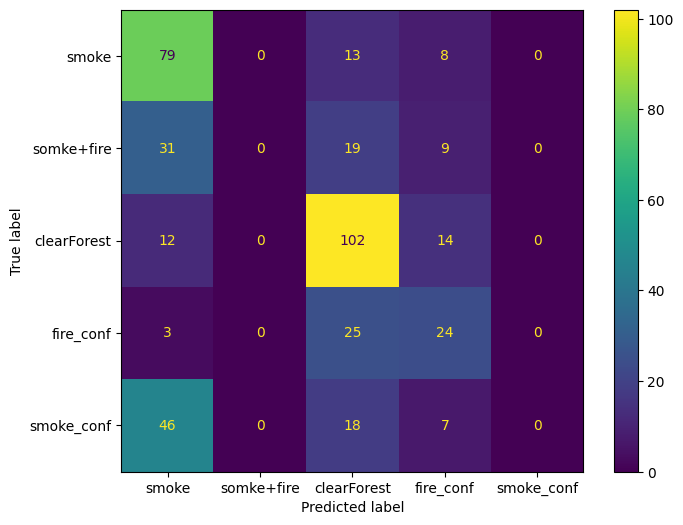

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=matrice_confusion,
                              display_labels=["smoke","somke+fire","clearForest","fire_conf","smoke_conf"])

disp.plot(ax=ax )
plt.show

In [57]:
import flatbuffers
# Convert the model (note: we are converting the model directly from the "model" variable)
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()
print(1)
# Let's save the model as "model_2.tflite"
tflite_model2_path = os.path.join(os.getcwd(),'model_tot.tflite')
with open(tflite_model2_path, 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\axelh\AppData\Local\Temp\tmpzx6wcv75\assets


INFO:tensorflow:Assets written to: C:\Users\axelh\AppData\Local\Temp\tmpzx6wcv75\assets


1
